# MLP



## 0. 변수 변형
- id: 지운다
- age: categorical로 바꾸어서 one-hot encoding
- workclass: 지운다
- fnlwgt: 지운다
- education: 지운다
- education_num: Minmax Scaler + 13이상 1, 13미만 0인 새 변수 생성
- marital_status: 'Married-civ-spouse'는 1, 나머지는 0
- occupation: one-hot encoding
- relationship: 지운다
- race: 'White' or 'Asian-Pac-Islander'는 1, 나머지는 0
- sex: one-hot encoding
- capital_gain: Minmax Scaler + 0이 아니다 1, 0이다 0
- capital_loss: Minmax Scaler + 0이 아니다 1, 0이다 0
- hours_per_week: Minmax Scaler + 50이상 1, 50미만 0인 새 변수 생성
- native_country: 지운다
- income = Target value -> 0('<=50K') or 1('>50K')

## 1. 최적 모델 선택
- layer 수, node 수: 많아도 크게 효과 없다. -> 최대한 줄였다.(16/16/1(output))
- regularizers: l1 사용, 나름 효과가 있음, 0.001로 설정
- dropout: 없는게 나음
- callback 함수: checkpoint만 사용

In [ ]:
# 1. 패키지 import
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


import os

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoonskyu","key":"d0dd946765ccff6f96ebaafcb8b36aa3"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle competitions download -c kakr-4th-competition
# !kaggle datasets list

  0% 0.00/683k [00:00<?, ?B/s]
100% 683k/683k [00:00<00:00, 43.6MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 54.7MB/s]
  0% 0.00/43.4k [00:00<?, ?B/s]
100% 43.4k/43.4k [00:00<00:00, 40.8MB/s]


In [ ]:
!ls
!unzip train.csv.zip

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
# 2. 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# 3. Preprocessing

# 1) column 제거
def col_reduction(df):
    df.drop(['id','fnlwgt','education','relationship','native_country','workclass'], axis=1, inplace=True)
    
    return df

# 2) marital_status 조정
def mar_st(df):
    df['marital_status'] = (df['marital_status'] == 'Married-civ-spouse').astype(int)
    
    return df

# 3) race 조정
def race(df):
    df['race'] = ((train['race'] == 'White') | (train['race'] == 'Asian-Pac-Islander')).astype(int)

    return df

# 4) capital_gain, loss 조정
def capital(df):
    df['cap_gain_high'] = (df['capital_gain'] != 0).astype(int)
    df['cap_loss_high'] = (df['capital_loss'] >= 1700).astype(int)
    df['capital_gain'] = df['capital_gain'].map(lambda x : np.log(x) if x != 0 else 0)
    
    return df

# 5) age 조정 함수
def age(df):
    df.loc[df['age'] < 20, 'age_range'] = '~20'
    df.loc[df['age'] >= 65, 'age_range'] = '~65'

    down = 20
    for i in range(45//5):
        df.loc[(df['age'] >= down) & (df['age'] < down+5), 'age_range'] = str(down)+'~'+str(down+5)
        down += 5

    df['age'] = df['age_range']
    df.drop(['age_range'], axis=1, inplace=True)
    
    return df
    
# 6) One-hot encoding은 만들지 않았다.

# 7) edu_num 새 변수 만들기
def edu(df):
    df['edu_num_high'] = (df['education_num'] >= 13).astype(int)
    
    return df

# 8) hpw 새 변수 만들기
    
def hpw(df):
    df['hpw_high'] = (df['hours_per_week'] >= 50).astype(int)

    return df

# 9) MinMaxScaler
def mm_feature(df, feature):
    mm_scaler = MinMaxScaler()
    
    df[feature] = mm_scaler.fit_transform(df[feature].values.reshape(-1,1))
    
    return df, mm_scaler

# 10) target 분리: train은 하고, test는 안하므로 따로 만들겠다.
def target_handle(df):
    df['income'] = df['income_>50K']
    df.drop(['income_>50K','income_<=50K'], axis=1, inplace=True)
    
    y_df = df.income
    X_df = df.drop(['income'], axis=1, inplace=False)
    
    return X_df, y_df

def main(df):
    
    df1 = col_reduction(df)
    df2 = mar_st(df1)
    df3 = race(df2)
    df4 = capital(df3)
    df5 = age(df4)
    
    df6 = pd.get_dummies(df5)
    
    df7 = edu(df6)
    df_fin = hpw(df7)
    
    return df_fin

In [ ]:
# 적용
## main: 1) ~ 7)
train = main(train)
X_test = main(test)

## 8) minmax scaler
train, mm_scaler1 = mm_feature(train, 'education_num')
train, mm_scaler2 = mm_feature(train, 'hours_per_week')
train, mm_scaler3 = mm_feature(train, 'capital_gain')
train, mm_scaler4 = mm_feature(train, 'capital_loss')

X_test['education_num'] = mm_scaler1.transform(X_test['education_num'].values.reshape(-1,1))
X_test['hours_per_week'] = mm_scaler2.transform(X_test['hours_per_week'].values.reshape(-1,1))
X_test['capital_gain'] = mm_scaler3.transform(X_test['capital_gain'].values.reshape(-1,1))
X_test['capital_loss'] = mm_scaler4.transform(X_test['capital_loss'].values.reshape(-1,1))

## 9) X, y split
X_train, y_train = target_handle(train)

In [ ]:
# train, validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=y_train)

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.001)))
# input_dim: feature 수, 다음 층에서는 적을 필요 없다.
# units는 생략 가능

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 16)                624       
_________________________________________________________________
dense_104 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
nb_epochs = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(X_val, y_val))

Epoch 1/100
209/209 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.7633 - val_loss: 0.4844 - val_accuracy: 0.8285
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 0.4514 - accuracy: 0.8377 - val_loss: 0.4334 - val_accuracy: 0.8462
Epoch 3/100
209/209 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.8421 - val_loss: 0.4201 - val_accuracy: 0.8459
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.4156 - accuracy: 0.8416 - val_loss: 0.4098 - val_accuracy: 0.8495
Epoch 5/100
209/209 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8451 - val_loss: 0.4023 - val_accuracy: 0.8459
Epoch 6/100
209/209 [==============================] - 0s 1ms/step - loss: 0.3996 - accuracy: 0.8443 - val_loss: 0.3975 - val_accuracy: 0.8459
Epoch 7/100
209/209 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8437 - val_loss: 0.3909 - val_accuracy: 0.8462

In [ ]:
train_acc = model.evaluate(X_train, y_train)
val_acc = model.evaluate(X_val, y_val)
# 분류 문제는 confusion matrix를 만들어서 평가

print("Train acc :", train_acc)
print("Val acc :", val_acc)

105/105 [==============================] - 0s 859us/step - loss: 0.3433 - accuracy: 0.8522
Train acc : [0.3441646099090576, 0.8492051362991333]
Val acc : [0.343267023563385, 0.852173924446106]


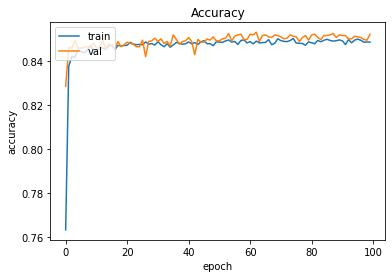

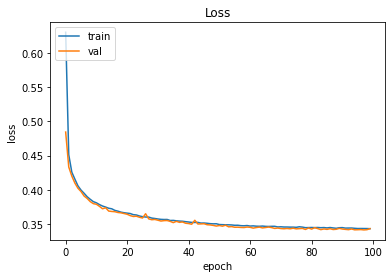

In [ ]:
# 시각화
plt.plot(history.history['accuracy']) # train acc
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # train acc
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
y_val_predict = np.rint(model.predict(X_val)).astype(int)

print(f1_score(y_val, y_val_predict, average='micro'))

0.8521739130434782


In [ ]:
y_test_predict = np.rint(model.predict(X_test)).astype(int)
sample_submission['prediction'] = y_test_predict
sample_submission.to_csv('submission_dl_default.csv', index=False)

0.7140663390663391

## 2. 데이터 조정
- 그대로 가져가기
    - val: 0.85217, test: 0.71407 (우리가 생각하는 그 수치는 아닌 것 같은데 왜 이렇게 나온지는 모르겠다.)
- education_num, capital_gain, capital_loss, hours_per_week에서 새로 만든 변수 제거
    - val: 0.84183, test: 0.68504
    - 나빠짐: 빼는 게 좋은 거는 아닌 듯..
- train, test 함께
    - val: 0.87732, test: 0.71422

In [ ]:
X_train_1 = X_train.drop(['edu_num_high','cap_gain_high','cap_loss_high','hpw_high'], axis = 1)
X_test_1 = X_test.drop(['edu_num_high','cap_gain_high','cap_loss_high','hpw_high'], axis = 1)

In [ ]:
# train, validation split
X_train_1, X_val_1, y_train, y_val = train_test_split(X_train_1, y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=y_train)

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X_train_1.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.001)))
# input_dim: feature 수, 다음 층에서는 적을 필요 없다.
# units는 생략 가능

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 16)                560       
_________________________________________________________________
dense_107 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 17        
Total params: 849
Trainable params: 849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
nb_epochs = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_1, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(X_val_1, y_val))

Epoch 1/100
167/167 [==============================] - 0s 2ms/step - loss: 0.6396 - accuracy: 0.7577 - val_loss: 0.5484 - val_accuracy: 0.7579
Epoch 2/100
167/167 [==============================] - 0s 1ms/step - loss: 0.4873 - accuracy: 0.8046 - val_loss: 0.4441 - val_accuracy: 0.8321
Epoch 3/100
167/167 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.8316 - val_loss: 0.4192 - val_accuracy: 0.8377
Epoch 4/100
167/167 [==============================] - 0s 1ms/step - loss: 0.4086 - accuracy: 0.8382 - val_loss: 0.4061 - val_accuracy: 0.8396
Epoch 5/100
167/167 [==============================] - 0s 1ms/step - loss: 0.3992 - accuracy: 0.8396 - val_loss: 0.3997 - val_accuracy: 0.8373
Epoch 6/100
167/167 [==============================] - 0s 1ms/step - loss: 0.3932 - accuracy: 0.8418 - val_loss: 0.3950 - val_accuracy: 0.8377
Epoch 7/100
167/167 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8431 - val_loss: 0.3907 - val_accuracy: 0.8381

In [ ]:
train_acc = model.evaluate(X_train_1, y_train)
val_acc = model.evaluate(X_val_1, y_val)
# 분류 문제는 confusion matrix를 만들어서 평가

print("Train acc :", train_acc)
print("Val acc :", val_acc)

84/84 [==============================] - 0s 1ms/step - loss: 0.3582 - accuracy: 0.8418
Train acc : [0.3471342921257019, 0.8474878072738647]
Val acc : [0.35824570059776306, 0.8418290615081787]


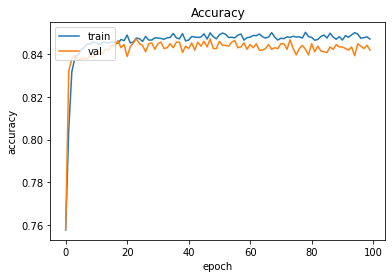

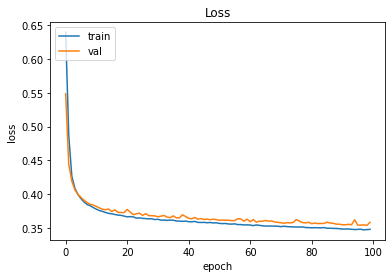

In [ ]:
# 시각화
plt.plot(history.history['accuracy']) # train acc
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # train acc
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
y_val_predict = np.rint(model.predict(X_val_1)).astype(int)

print(f1_score(y_val, y_val_predict, average='micro'))

0.8418290854572713


In [ ]:
y_test_predict = np.rint(model.predict(X_test_1)).astype(int)
sample_submission['prediction'] = y_test_predict
sample_submission.to_csv('submission_dl_delete_col.csv', index=False)

0.6850429975429976

In [ ]:
# train, test 합치기 - default 과정 선행 필요
X_train_2 = pd.concat([X_train, X_test])

In [ ]:
y_test = pd.read_csv('submission_dl_default.csv')

In [ ]:
y_test = y_test.iloc[:,1]

In [ ]:
y_train_2 = pd.concat([y_train, y_test])

In [ ]:
# train, validation split
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=y_train_2)

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X_train_2.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.001)))
# input_dim: feature 수, 다음 층에서는 적을 필요 없다.
# units는 생략 가능

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 16)                624       
_________________________________________________________________
dense_110 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
nb_epochs = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_2, y_train_2,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(X_val_2, y_val_2))

Epoch 1/100
407/407 [==============================] - 1s 2ms/step - loss: 0.4985 - accuracy: 0.8339 - val_loss: 0.3937 - val_accuracy: 0.8620
Epoch 2/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3808 - accuracy: 0.8648 - val_loss: 0.3685 - val_accuracy: 0.8629
Epoch 3/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3644 - accuracy: 0.8657 - val_loss: 0.3555 - val_accuracy: 0.8641
Epoch 4/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3545 - accuracy: 0.8672 - val_loss: 0.3484 - val_accuracy: 0.8635
Epoch 5/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3476 - accuracy: 0.8675 - val_loss: 0.3438 - val_accuracy: 0.8672
Epoch 6/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3430 - accuracy: 0.8692 - val_loss: 0.3418 - val_accuracy: 0.8629
Epoch 7/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3392 - accuracy: 0.8685 - val_loss: 0.3357 - val_accuracy: 0.8638

In [ ]:
train_acc = model.evaluate(X_train_2, y_train_2)
val_acc = model.evaluate(X_val_2, y_val_2)
# 분류 문제는 confusion matrix를 만들어서 평가

print("Train acc :", train_acc)
print("Val acc :", val_acc)

204/204 [==============================] - 0s 879us/step - loss: 0.3008 - accuracy: 0.8773
Train acc : [0.3009794056415558, 0.8774186372756958]
Val acc : [0.30075132846832275, 0.877322256565094]


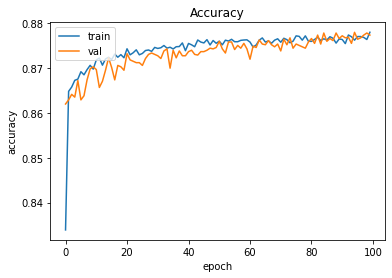

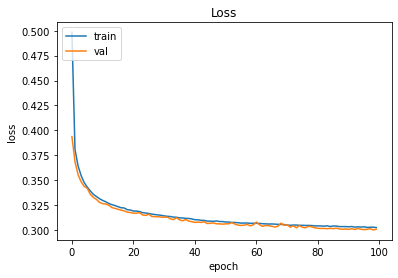

In [ ]:
# 시각화
plt.plot(history.history['accuracy']) # train acc
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # train acc
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
y_val_predict = np.rint(model.predict(X_val_2)).astype(int)

print(f1_score(y_val_2, y_val_predict, average='micro'))

0.8773222785198833


In [ ]:
y_test_predict = np.rint(model.predict(X_test)).astype(int)
sample_submission['prediction'] = y_test_predict
sample_submission.to_csv('submission_dl_train_test_concat.csv', index=False)

0.7142199017199017